# imports

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
import xgboost as xgb
from collections import Counter
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from IPython.core.display import display, HTML
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

Duplicate key in file '/Users/galmoore/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


# load data

In [2]:
df = pd.read_csv("interview_dataset_train", sep='\t', lineterminator='\r')
# remove "\n" in #viewed_ads
df["#viewed_ads"] =  df["#viewed_ads"].str.replace("\n","")
print(df.shape)
df.head(2)

(80000, 12)


,#viewed_ads,#times_visited_website,#products_in_cart,target_product_price,target_product_price_color,target_product_description_length,timestamp,target_product_category,age,shopper_segment,delivery_time,tag
0,16,7.0,8,36,red,91,17:43:06,Video games - fifa 18,25.0,new,1-3 days,1
1,10,6.0,6,34,black,157,23:19:06,video games - nba 2k,NaN,new,4-8 days,1


# check for missing values

In [3]:
df.isnull().sum()

#viewed_ads                              0
#times_visited_website               16141
#products_in_cart                        0
target_product_price                     0
target_product_price_color               0
target_product_description_length        0
timestamp                                0
target_product_category                  0
age                                  16137
shopper_segment                          0
delivery_time                            0
tag                                      0
dtype: int64

# Check class balance

20747 purchases out of  80000 
That's a ratio of 1: 3.5


<AxesSubplot:>

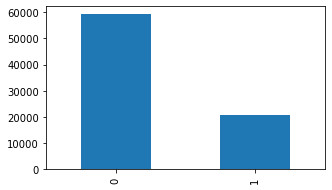

In [4]:
ratio = len(df[df["tag"]==1])/len(df[df["tag"]==0])
print(len(df[df["tag"]==1]),"purchases out of ",len(df),"\nThat's a ratio of 1:",round(10*ratio,2))
df["tag"].value_counts().plot.bar(figsize=(5,3))

# Visualise all features

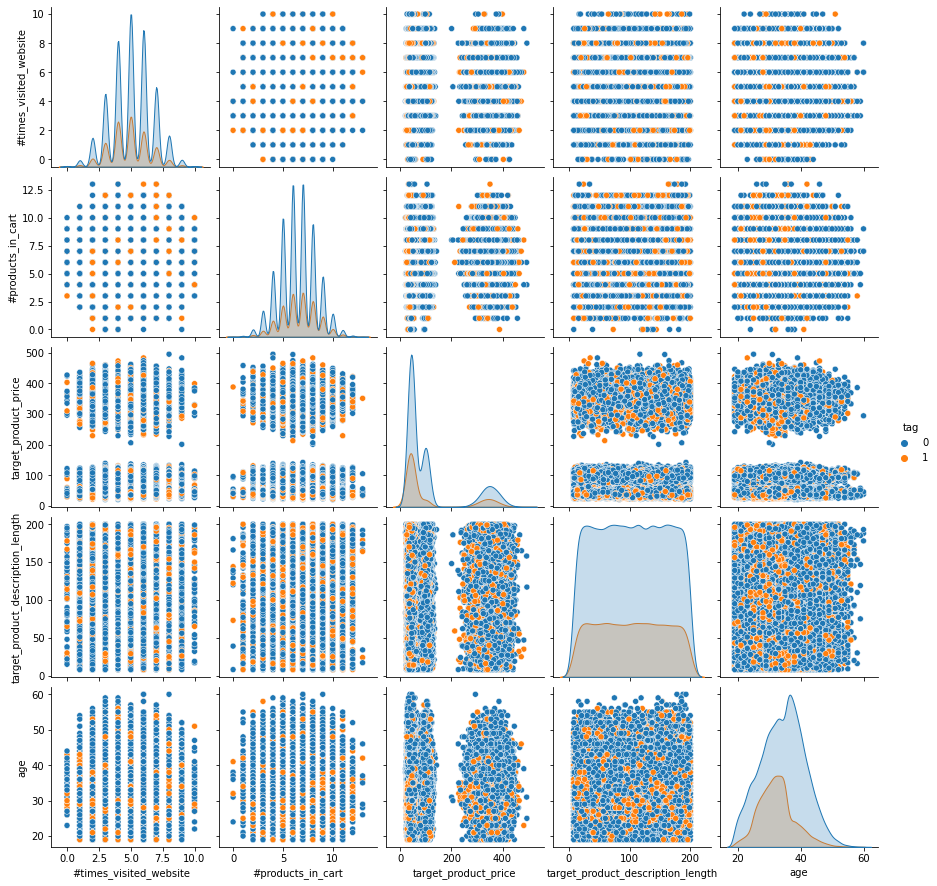

In [5]:
# %%time
sns.pairplot(df,hue='tag') 

There are a few things we can tell from this plot already: 
* average age of shopper is around 40. But average purchaser ('tag'==1) is a bit younger.
* Production description length is not going to be a very predictive feature.
* all customers generally look at cheaper products - and that is also where the majority of purchases are.

We will further explore each feature below

## viewed_ads

<AxesSubplot:>

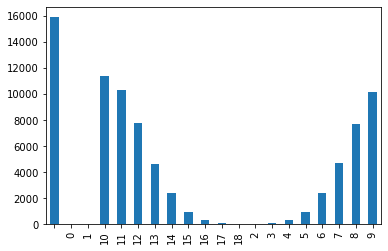

In [6]:
df["#viewed_ads"].value_counts().sort_index().plot.bar()

It seems that there is a blank entry for almost 16k rows in this column. 
The rest of the data seems to be distributed normally around 9 or 10. Let's fill in the empty rows with normally distributed data similar to that of the rest of this feature.

In [7]:
mu, sigma = 10, 2 
s = np.random.normal(mu, sigma, 15911)
s = s.round(decimals=0)
df_empty_strings = df[df["#viewed_ads"]==""]
df_empty_strings["#viewed_ads"] = s
df_non_empty_strings = df[df["#viewed_ads"]!=""]
df = pd.concat([df_empty_strings,df_non_empty_strings],ignore_index=True)
df["#viewed_ads"] = df["#viewed_ads"].astype(float) 

<AxesSubplot:>

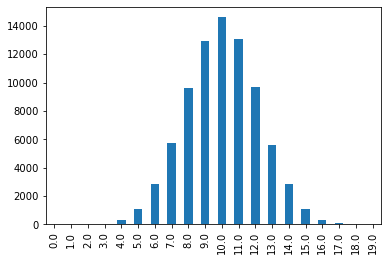

In [8]:
df["#viewed_ads"].value_counts().sort_index().plot.bar()

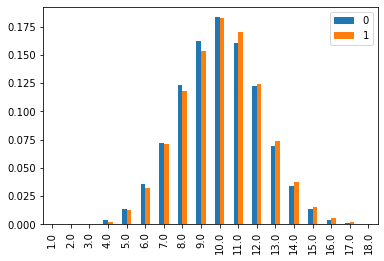

In [9]:
def plot_view_ads(df,feature):
    df[feature].replace("", np.nan, inplace=True)
    df.dropna(inplace=True)
    if(feature=="#viewed_ads"):
        df[feature] = df[feature].astype(float)
    df.reset_index(drop=True, inplace=True) 
    s1 = df[feature][df["tag"]==0].value_counts(normalize=True)
    s2 = df[feature][df["tag"]==1].value_counts(normalize=True)
    comb_df = pd.concat([s1,s2],axis=1,ignore_index=True)
    comb_df.plot.bar()
    
plot_view_ads(df.copy(),"#viewed_ads")

Seems that the ratio between those that buy and those that don't is steady regardless of the amount of ads seen.

## times visited website

We know that we have missing values in this column. Let's decide later how to handle this. 

<AxesSubplot:>

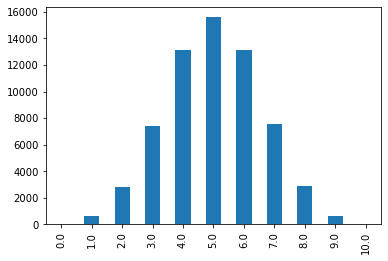

In [10]:
df["#times_visited_website"].value_counts().sort_index().plot.bar()

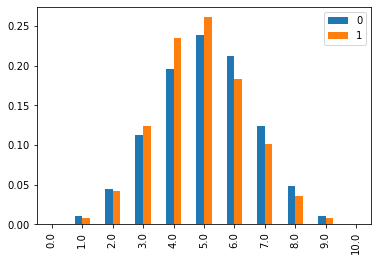

In [11]:
def plot_times_visited_website(df,feature):
    s1 = df[feature][df["tag"]==0].value_counts(normalize=True)
    s2 = df[feature][df["tag"]==1].value_counts(normalize=True)
    comb_df = pd.concat([s1,s2],axis=1,ignore_index=True)
    comb_df.plot.bar()
    
plot_times_visited_website(df.copy(),"#times_visited_website")

Like the previous feature it does not seem that the amount of visits to the website is very strongly predictive of the purchase outcome.

## products in cart

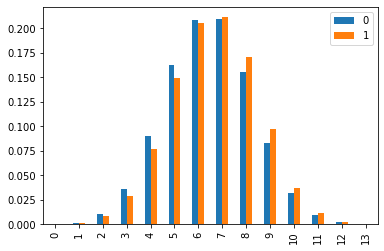

In [12]:
def plot_products_in_cart(df,feature):
    s1 = df[feature][df["tag"]==0].value_counts(normalize=True)
    s2 = df[feature][df["tag"]==1].value_counts(normalize=True)
    comb_df = pd.concat([s1,s2],axis=1,ignore_index=True)
    comb_df.plot.bar()
    
plot_products_in_cart(df.copy(),"#products_in_cart")

The more items are added to the cart the more likely it is that the user will make a purchase - but only slightly. 

## price

applying min_thresh at 0 and max_thresh at 1000


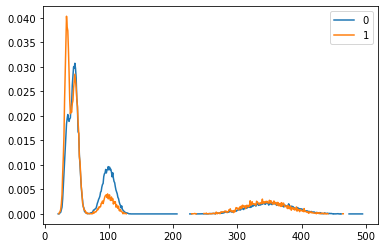

In [13]:
def plot_product_price(df,feature,min_thresh=0,max_thresh=1000):
    s1 = df[feature][df["tag"]==0].value_counts(normalize=True)
    s2 = df[feature][df["tag"]==1].value_counts(normalize=True)
    comb_df = pd.concat([s1,s2],axis=1,ignore_index=True)
    print("applying min_thresh at {} and max_thresh at {}".format(min_thresh,max_thresh))
    comb_df[(comb_df.index>min_thresh)&(comb_df.index<max_thresh)].plot()
    
plot_product_price(df.copy(),"target_product_price")

Looks like small ticket products are much more likely to sell - between 20 and 40 USD. Around the 100 USD mark users are much less likely to make a purchase at a given visit. 

## Colour

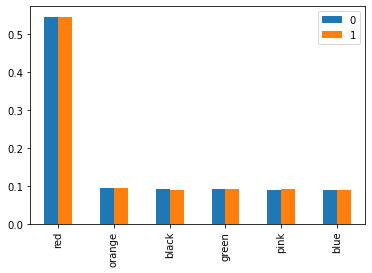

In [14]:
def plot_colour(df,feature):
    s1 = df[feature][df["tag"]==0].value_counts(normalize=True)
    s2 = df[feature][df["tag"]==1].value_counts(normalize=True)
    comb_df = pd.concat([s1,s2],axis=1,ignore_index=True)
    comb_df.plot.bar()
    
plot_colour(df,"target_product_price_color")

It appears that the colour of the button does not strongly effect the decision to buy. A customer is as likely to buy or not regardless of the colour.

## Description length

In [15]:
df["target_product_description_length"][df["tag"]==0].describe()

count    59253.000000
mean       104.077903
std         55.693950
min          8.000000
25%         56.000000
50%        104.000000
75%        152.000000
max        200.000000
Name: target_product_description_length, dtype: float64

In [16]:
df["target_product_description_length"][df["tag"]==1].describe()

count    20747.000000
mean       103.265918
std         55.498694
min          8.000000
25%         55.000000
50%        103.000000
75%        151.000000
max        200.000000
Name: target_product_description_length, dtype: float64

Description lengths are almost identical - and not very predictive of our target.

## timestamp

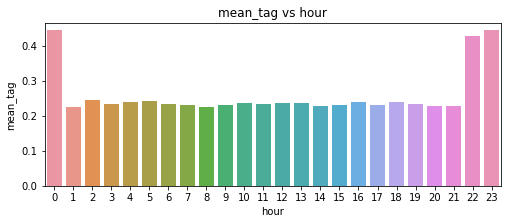

In [17]:
def add_new_date_time_features(dataset): # pickup time and tdatae availabel only
    dataset['datetime'] = pd.to_datetime(arg=dataset['timestamp'], infer_datetime_format=True) 
    dataset['hour'] = dataset.datetime.dt.hour
    return dataset

data = add_new_date_time_features(df)

def groupandplot(data,groupby_key,value,aggregate='mean'):
    plt.figure(figsize=(18,3))
    agg_data=data.groupby([groupby_key])[value].agg(aggregate).reset_index().rename(columns={value:aggregate+'_'+value})
    plt.subplot(1,2,1)
    sns.barplot(x=groupby_key,y=aggregate+'_'+value,data=agg_data).set_title(aggregate+'_'+value+" vs "+groupby_key)
groupandplot(data,'hour','tag')

Looks like hour is a strong feature. Let's create such a feature and add it to the df


In [18]:
df['datetime'] = pd.to_datetime(arg=df['timestamp'], infer_datetime_format=True) 
df['hour'] = df.datetime.dt.hour

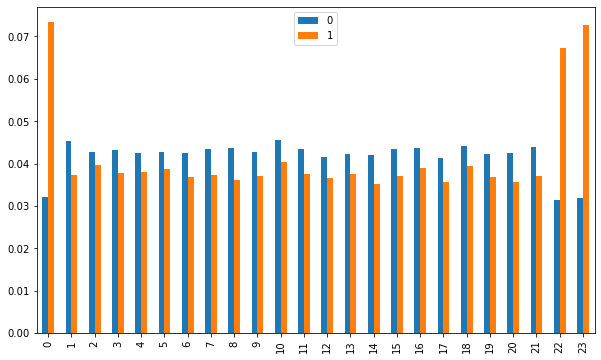

In [19]:
def plot_timestamp(df,feature):
    s1 = df[feature][df["tag"]==0].value_counts(normalize=True)
    s2 = df[feature][df["tag"]==1].value_counts(normalize=True)
    comb_df = pd.concat([s1,s2],axis=1,ignore_index=True)
    comb_df.plot.bar(figsize=(10,6))
    
plot_timestamp(df.copy(),"hour")

It is clear that between 22:00 - 1am users are much more likely to make a purchase. Hour should have strong predictive power.

## product category

Here I identified an issue with capitalisation and fixed it. 

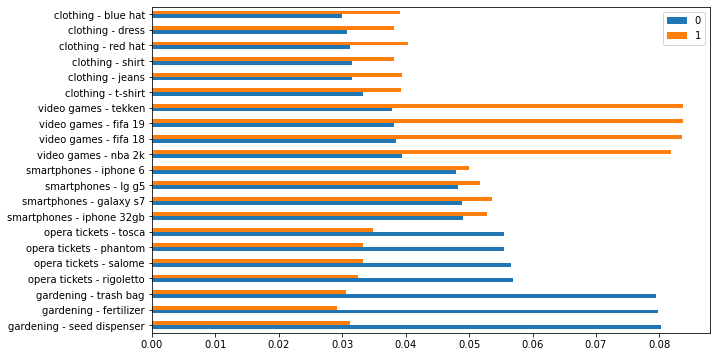

In [20]:
df["target_product_category"] = df["target_product_category"].str.lower()
def plot_category(df,feature):
    s1 = df[feature][df["tag"]==0].value_counts(normalize=True)
    s2 = df[feature][df["tag"]==1].value_counts(normalize=True)
    comb_df = pd.concat([s1,s2],axis=1,ignore_index=True)
    comb_df.plot.barh(figsize=(10,6))
    
plot_category(df.copy(),"target_product_category")

Per visit, users are much more likely to purchase a product if it is a video game or item of clothing. Opera tickets and gardening supplies are looked at often -but purchased less often on average per visit.

## age

We know there are missing values here. We will later decide how to handle that.

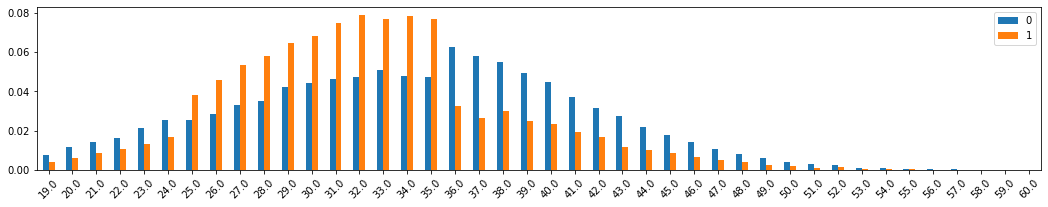

In [21]:
def plot_category(df,feature):
    s1 = df[feature][df["tag"]==0].value_counts(normalize=True)
    s2 = df[feature][df["tag"]==1].value_counts(normalize=True)
    comb_df = pd.concat([s1,s2],axis=1,ignore_index=True)
    comb_df.plot.bar(figsize=(18,3),rot=45)
    
plot_category(df.copy(),"age")

It is clear from that data we have that people between 25 and 35 are much more likely to make a purchase on any given visit.

## Shopper segment

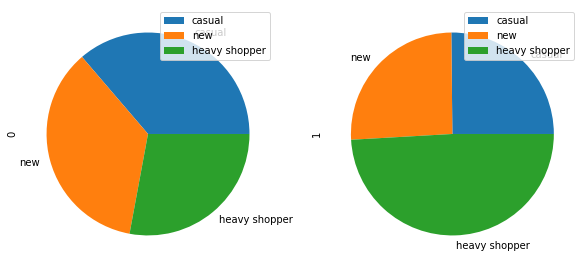

In [22]:
def plot_seg(df,feature):
    s1 = df[feature][df["tag"]==0].value_counts(normalize=True)
    s2 = df[feature][df["tag"]==1].value_counts(normalize=True)
    comb_df = pd.concat([s1,s2],axis=1,ignore_index=True)
    comb_df.plot.pie(subplots=True,figsize=(10,10))
    
plot_seg(df.copy(),"shopper_segment")

Another strong feature. The distribution of visits that did not end in a purchase show equal presence of the three  categories. But visits that end in a purchase are overwhelmingly done by those classified as 'Heavy shoppers'. We will late bunch these up into two categories - due to the similarity in behaviour between casual and new users.

## Delivery time

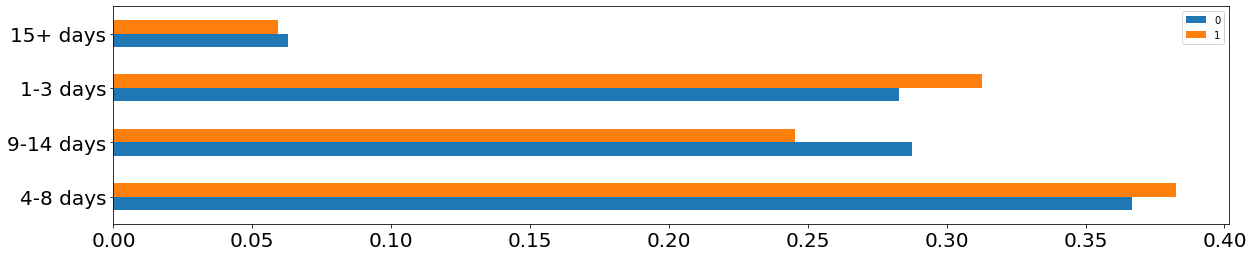

In [47]:
def plot_del_time(df,feature):
    s1 = df[feature][df["tag"]==0].value_counts(normalize=True)
    s2 = df[feature][df["tag"]==1].value_counts(normalize=True)
    comb_df = pd.concat([s1,s2],axis=1,ignore_index=True)
    comb_df.plot.barh(figsize=(20,4),fontsize=20)
    
plot_del_time(df.copy(),"delivery_time")

People might be more likely to buy products if they arrive sooner. However this feature could be misleading to our model - as new items could have high popularity even if they take longer to ship. The delivery time for any given product could change too - which might not necessarily make it less purchasable. 

# Label encoding

Convert categorical labels to numerical ones.

In [24]:
# le_colour.classes_
le_colour = preprocessing.LabelEncoder()
le_colour.fit(df["target_product_price_color"])
df["target_product_price_color"] = le_colour.transform(df["target_product_price_color"])
# category
le_cat = preprocessing.LabelEncoder()
le_cat.fit(df["target_product_category"])
df["target_product_category"] = le_cat.transform(df["target_product_category"])
# segment
le_seg = preprocessing.LabelEncoder()
le_seg.fit(df["shopper_segment"])
df["shopper_segment"] = le_seg.transform(df["shopper_segment"])
df["shopper_segment"].loc[df["shopper_segment"]==2] = 0
# delivery time
le_del = preprocessing.LabelEncoder()
le_del.fit(df["delivery_time"])
df["delivery_time"] = le_del.transform(df["delivery_time"])
df["delivery_time"]
print(df.shape)

(80000, 14)


# Explore feature combinations

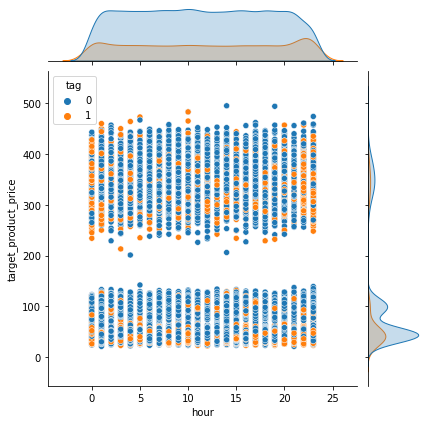

In [25]:
sns.jointplot(x=df['hour'], y=df['target_product_price'],hue=df['tag']);

We can get some intution here. Looks like there are two distinct price ranges. We already know that the busy hours for purchases are between 22:00 - 1am. We see that this is the case across price ranges - and even more so on high ticket items.

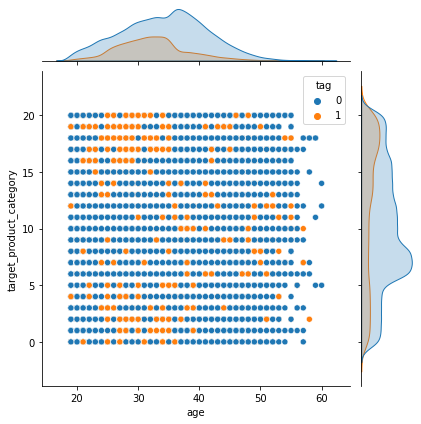

In [26]:
sns.jointplot(x=df['age'], y=df['target_product_category'],hue=df['tag']);

Here we can see that most shopping is done by the 25-35 age bracket. They are especially interested in the first 5 categories and the last 5 - let's see what these are.

In [27]:
print("Popular amongst 25-35 yo - first 5 categories:\n",le_cat.classes_[-5:])
print("\nPopular amongst 25-35 yo - last 5 categories:\n",le_cat.classes_[:5])
print("\nover 50s seem to be more intested in:\n",le_cat.classes_[6:12])

Popular amongst 25-35 yo - first 5 categories:
 ['smartphones - lg g5' 'video games - fifa 18' 'video games - fifa 19'
 'video games - nba 2k' 'video games - tekken']

Popular amongst 25-35 yo - last 5 categories:
 ['clothing - blue hat' 'clothing - dress' 'clothing - jeans'
 'clothing - red hat' 'clothing - shirt']

over 50s seem to be more intested in:
 ['gardening - fertilizer' 'gardening - seed dispenser'
 'gardening - trash bag' 'opera tickets - phantom'
 'opera tickets - rigoletto' 'opera tickets - salome']


<AxesSubplot:xlabel='shopper_segment', ylabel='age'>

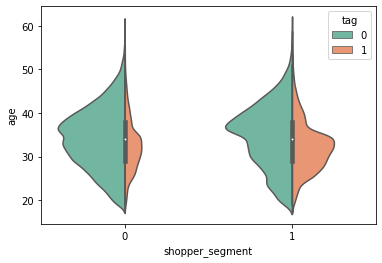

In [28]:
sns.violinplot(x="shopper_segment", y="age", hue="tag",
                    data=df, palette="Set2", split=True,
                    scale="count")

 We can clearly see that our heavy shoppers are in the age range where most purchases are made: the 25-35 age bracket.

------------------------------------

# baseline comparison of various models

Great! So we've cleaned up the data and added an 'hour' feature. Now we want to decide what do with nulls in 'age' and '#times_visited_website' columns. For the first model let's get rid of these rows entirely

In [29]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(50998, 14)

We have given up on alot of data (from 80k to 51k). But this is enough to train a few baseline models.

In [30]:
train_df = df.drop(["timestamp","datetime",],axis=1)
X = train_df.drop(["tag"],axis=1).values
y = train_df["tag"].values

In [31]:
Counter(train_df["tag"])

Counter({1: 13269, 0: 37729})

The ratio of our target classes has not been dramatically effected. We can proceed.

In [32]:
def run_training(X, y, CV=5, models=[
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),MultinomialNB(),LogisticRegression(random_state=0),
    KNeighborsClassifier(),XGBClassifier(learning_rate = 0.1)]):

    X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True)
    print("X_train: ",X_train.shape)
    print("X_test:",X_test.shape)
    print("y_train:",y_train.shape)
    print("y_test:",y_test.shape)

    entries = []

    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))

    cv_df = pd.DataFrame(index=range(CV * len(models)))    
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    plt.figure(figsize=(12,6))
    sns.boxplot(x='model_name', y='accuracy', data=cv_df, 
                color='lightblue', showmeans=True)
    plt.title("MEAN ACCURACY (cv = {})\n".format(CV), size=14);

    for count, model in enumerate(models):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            print(Counter(y_pred))
            from sklearn import metrics
            print("\t {} accuracy score: {}\n".format(model.__class__.__name__,model.score(X_test,y_test)))
            print("\t[training score: ",model.fit(X_train, y_train).score(X_train, y_train),"]\n")
            print(metrics.classification_report(y_test, y_pred)) 

We run training on 6 different models and for each one Kfolds cross valdiation with 5 folds focusing on accuracy score.

X_train:  (38248, 11)
X_test: (12750, 11)
y_train: (38248,)
y_test: (12750,)
Counter({0: 11445, 1: 1305})
	 RandomForestClassifier accuracy score: 0.804235294117647

	[training score:  0.8058722024681029 ]

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      9411
           1       0.82      0.32      0.46      3339

    accuracy                           0.80     12750
   macro avg       0.81      0.65      0.67     12750
weighted avg       0.81      0.80      0.77     12750

Counter({0: 11666, 1: 1084})
	 LinearSVC accuracy score: 0.7390588235294118

	[training score:  0.7404831625183016 ]

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      9411
           1       0.51      0.16      0.25      3339

    accuracy                           0.74     12750
   macro avg       0.63      0.55      0.54     12750
weighted avg       0.69      0.74      0.69     12750

Counter({0: 6808, 1: 

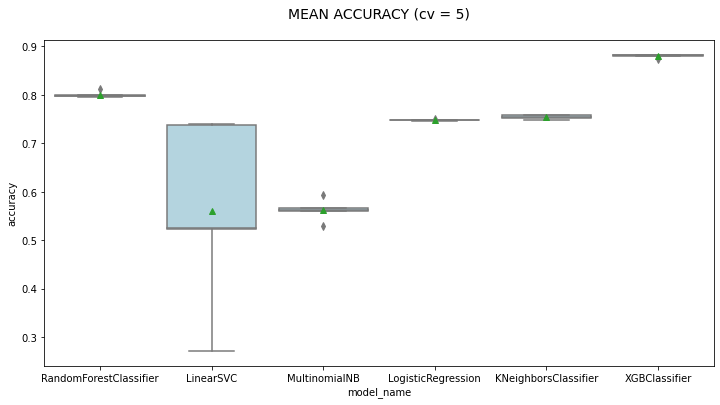

In [33]:
run_training(X,y)

Looks like XGBoost is performing best here. Though recall and f1 score of class 1 is not great. 

Lets focus on XGBoost going forward and see how far we can go. We would like to get a good weighted avg f1 with high recall and precision. 

XGBoost can handle null values on its own which is useful.

Lets create a simple pipeline with all the data this time and let XGBoost handle 
imputation of missing values.

# XGboost model with full dataset

## load data, fill missing values with normal distribution around mean & remove capitlaistion and label encoding

In [34]:
df = pd.read_csv("interview_dataset_train", sep='\t', lineterminator='\r')

def clean_train(df):
    df["#viewed_ads"] =  df["#viewed_ads"].str.replace("\n","")
    mu, sigma = 10, 2 # mean and standard deviation
    s = np.random.normal(mu, sigma, 15911)
    s = s.round(decimals=0)
    df_empty_strings = df[df["#viewed_ads"]==""]
    df_empty_strings["#viewed_ads"] = s
    df_non_empty_strings = df[df["#viewed_ads"]!=""]
    df = pd.concat([df_empty_strings,df_non_empty_strings],ignore_index=True)
    df["#viewed_ads"] = df["#viewed_ads"].astype(float)
    df["target_product_category"] = df["target_product_category"].str.lower()   
    # le_colour.classes_
    le_colour = preprocessing.LabelEncoder()
    le_colour.fit(df["target_product_price_color"])
    df["target_product_price_color"] = le_colour.transform(df["target_product_price_color"])
    # add hour feature
    df['datetime'] = pd.to_datetime(arg=df['timestamp'], infer_datetime_format=True) 
    df['hour'] = df.datetime.dt.hour
    # category
    le_cat = preprocessing.LabelEncoder()
    le_cat.fit(df["target_product_category"])
    df["target_product_category"] = le_cat.transform(df["target_product_category"])
    # segment
    le_seg = preprocessing.LabelEncoder()
    le_seg.fit(df["shopper_segment"])
    df["shopper_segment"] = le_seg.transform(df["shopper_segment"])
    df["shopper_segment"].loc[df["shopper_segment"]==2] = 0
    # delivery time
    le_del = preprocessing.LabelEncoder()
    le_cat.fit(df["delivery_time"])
    df["delivery_time"] = le_cat.transform(df["delivery_time"])
    df["delivery_time"]
    print(df.shape)
    return df

df = clean_train(df)

(80000, 14)


### xgboost training

In [35]:
def run_training_XG(X, y, early_n=30,plot=False,CV=5, 
                    models=[XGBClassifier(learning_rate = 0.1, n_estimators=150, min_child_weight=3,  max_depth=13,scale_pos_weight=1)]
                   ,feature_importance=False):

    X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    print("X_train: ",X_train.shape)
    print("X_test:",X_test.shape)
    print("y_train:",y_train.shape)
    print("y_test:",y_test.shape)
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))

    cv_df = pd.DataFrame(index=range(CV * len(models)))    
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    plt.figure(figsize=(12,6))
    sns.boxplot(x='model_name', y='accuracy', data=cv_df, 
                color='lightblue', showmeans=True)
    plt.title("MEAN ACCURACY (cv = {})\n".format(CV), size=14);
    
    print("\ntraining score: ",model.fit(X_train, y_train).score(X_train, y_train),"\n")

    for count, model in enumerate(models):
            model.fit(X_train, y_train,early_stopping_rounds=early_n, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
            y_pred = model.predict(X_test)
            from sklearn import metrics
            print("\t {} accuracy score: {}\n".format(model.__class__.__name__,model.score(X_test,y_test)))
            print("\t[training score: ",model.fit(X_train, y_train).score(X_train, y_train),"]\n")
            print(metrics.classification_report(y_test, y_pred)) 
            if(plot==True):
                predictions = [round(value) for value in y_pred]
                accuracy = accuracy_score(y_test, predictions)
                results = model.evals_result()
                epochs = len(results['validation_0']['error'])
                x_axis = range(0, epochs)
                    # plot log loss
                fig, ax = plt.subplots(figsize=(12,6))
                ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
                ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
                ax.legend()
                plt.ylabel('Log Loss')
                plt.title('XGBoost Log Loss')
                plt.show()

                # plot classification error
                fig, ax = plt.subplots(figsize=(12,6))
                ax.plot(x_axis, results['validation_0']['error'], label='Train')
                ax.plot(x_axis, results['validation_1']['error'], label='Test')
                ax.legend()
                plt.ylabel('Classification Error')
                plt.title('XGBoost Classification Error')
                plt.show()
            if(feature_importance==True):
                df_importance = pd.DataFrame(model.feature_importances_)
                df_importance.index = training_df.drop(["tag"],axis=1).columns
                df_importance.plot.barh(figsize=(12,6))
    

Previously we trained on the 51k rows that remained after removing nulls. This time we are giving all 80k rows to our model.

X_train:  (60000, 11)
X_test: (20000, 11)
y_train: (60000,)
y_test: (20000,)

training score:  0.8660666666666667 

	 XGBClassifier accuracy score: 0.8511

	[training score:  0.8648666666666667 ]

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     14735
           1       0.80      0.58      0.67      5265

    accuracy                           0.85     20000
   macro avg       0.83      0.76      0.79     20000
weighted avg       0.85      0.85      0.84     20000



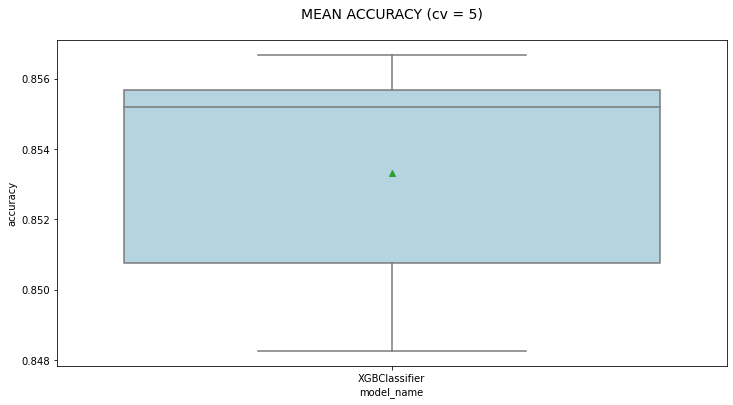

In [36]:
training_df = df.drop([
              "timestamp","datetime"],axis=1)
X = training_df.drop(["tag"],axis=1).values
y = training_df["tag"].values

run_training_XG(X,y,models=[XGBClassifier(learning_rate = 0.1)])

We had better results previously when we removed all null rows. But we want to preserve as much data as possible. Our minority class is not performing very well. Let's try oversampling to give our model a more accurate view of the data. 

## Oversampling

before oversampling: Counter({0: 59253, 1: 20747})
after oversampling: Counter({1: 59253, 0: 59253})

X_train:  (88879, 11)
X_test: (29627, 11)
y_train: (88879,)
y_test: (29627,)

training score:  0.8036656578044308 

	 XGBClassifier accuracy score: 0.7979883214635299

	[training score:  0.8036656578044308 ]

              precision    recall  f1-score   support

           0       0.76      0.88      0.81     14835
           1       0.86      0.71      0.78     14792

    accuracy                           0.80     29627
   macro avg       0.81      0.80      0.80     29627
weighted avg       0.81      0.80      0.80     29627



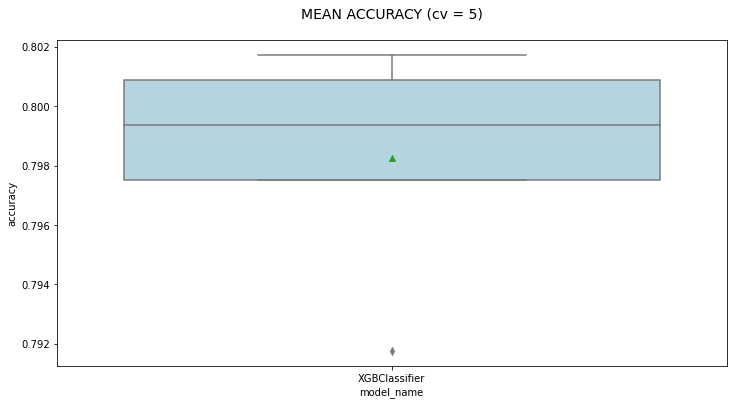

In [37]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)
print("before oversampling:",Counter(y))
print("after oversampling:",Counter(y_ros))
print("")
run_training_XG(X_ros,y_ros,models=[XGBClassifier(learning_rate = 0.1)])

Our f1 and recall have improved for our minority class (tag==1) but at the expense of our majority class (tag==0) precision, recall and accuracy. Can we find a middle ground or a situation where we get good results for both classes?

# Change XGBClassifer hyperparams

## Make model more complex to improve accuracy: plot learning curve and feature importance as final sanity check

X_train:  (88879, 11)
X_test: (29627, 11)
y_train: (88879,)
y_test: (29627,)

training score:  0.9979747746936847 

	 XGBClassifier accuracy score: 0.9294899922368111

	[training score:  0.9979747746936847 ]

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     14689
           1       0.92      0.94      0.93     14938

    accuracy                           0.93     29627
   macro avg       0.93      0.93      0.93     29627
weighted avg       0.93      0.93      0.93     29627



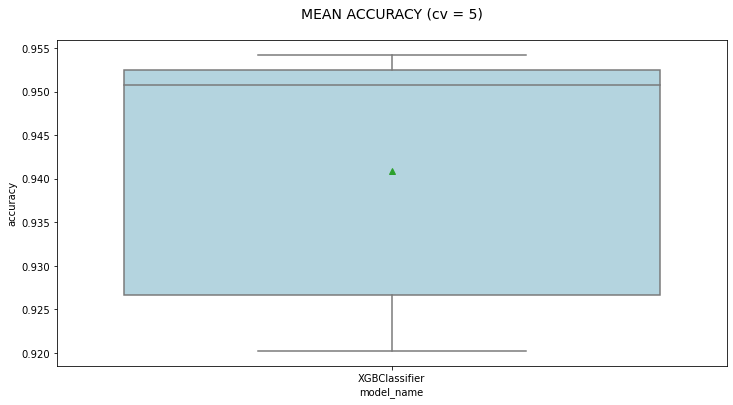

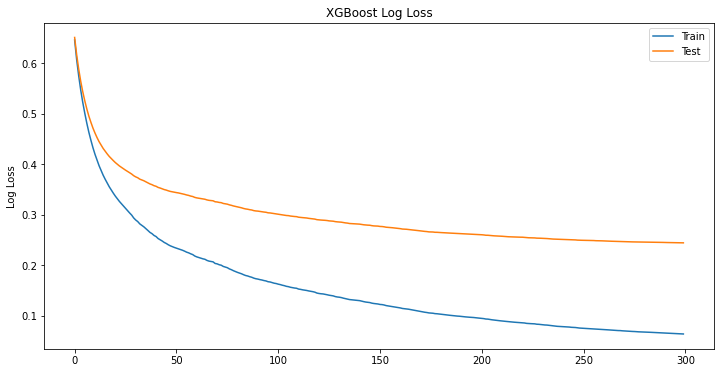

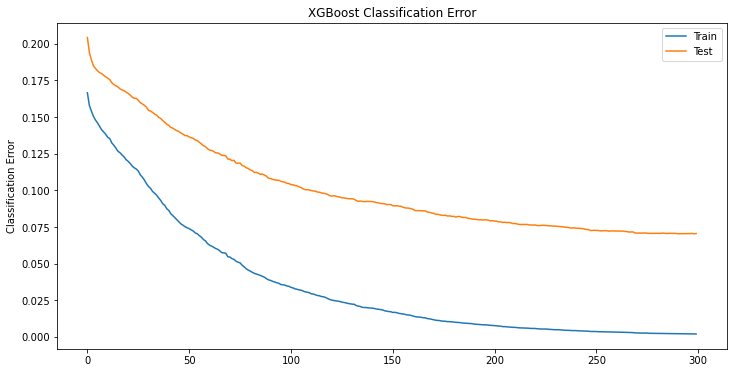

CPU times: user 29min 13s, sys: 51.4 s, total: 30min 5s
Wall time: 4min 21s


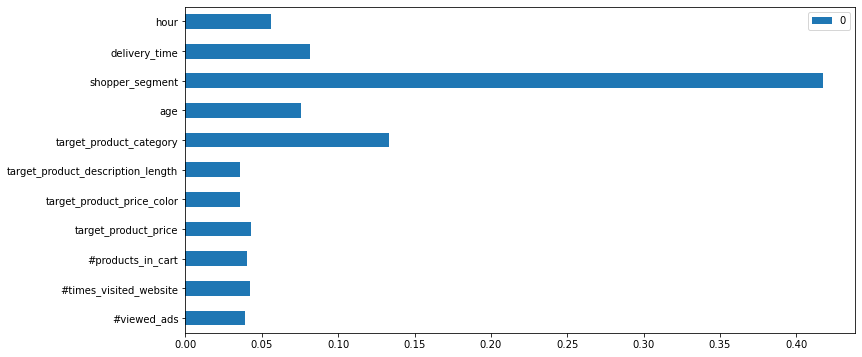

In [38]:
%%time
run_training_XG(X_ros,y_ros,plot=True,models=[XGBClassifier(learning_rate = 0.1,
                                                            n_estimators=300, 
                                                            min_child_weight=3,  
                                                            max_depth=15)],
                                                            feature_importance=True)

We have >.90 f1 for both classes and we leveraged our existing data as much as possible. Let's check that the features are effecting the model as expected.

# import unseen test set, preprocessing and save predictions to file

In [39]:
df_unseen = pd.read_csv("interview_dataset_test_no_tags", sep='\t', lineterminator='\r')

def clean_test(df):
    df["#viewed_ads"] =  df["#viewed_ads"].str.replace("\n","")
    mu, sigma = 10, 2 # mean and standard deviation
    s = np.random.normal(mu, sigma, 3996)
    s = s.round(decimals=0)
    df_empty_strings = df[df["#viewed_ads"]==""]
    df_empty_strings["#viewed_ads"] = s
    df_non_empty_strings = df[df["#viewed_ads"]!=""]
    df = pd.concat([df_empty_strings,df_non_empty_strings],ignore_index=True)
    df["#viewed_ads"] = df["#viewed_ads"].astype(float)
    df["target_product_category"] = df["target_product_category"].str.lower()   
    # le_colour.classes_
    le_colour = preprocessing.LabelEncoder()
    le_colour.fit(df["target_product_price_color"])
    df["target_product_price_color"] = le_colour.transform(df["target_product_price_color"])
    # add hour feature
    df['datetime'] = pd.to_datetime(arg=df['timestamp'], infer_datetime_format=True) 
    df['hour'] = df.datetime.dt.hour
    # category
    le_cat = preprocessing.LabelEncoder()
    le_cat.fit(df["target_product_category"])
    df["target_product_category"] = le_cat.transform(df["target_product_category"])
    # segment
    le_seg = preprocessing.LabelEncoder()
    le_seg.fit(df["shopper_segment"])
    df["shopper_segment"] = le_seg.transform(df["shopper_segment"])
    df["shopper_segment"].loc[df["shopper_segment"]==2] = 0
    # delivery time
    le_del = preprocessing.LabelEncoder()
    le_cat.fit(df["delivery_time"])
    df["delivery_time"] = le_cat.transform(df["delivery_time"])
    print(df.shape)
    return df

df_unseen = clean_test(df_unseen)

(20000, 13)


In [40]:
df_unseen = df_unseen.drop(["timestamp","datetime",],axis=1)
df_unseen.shape

(20000, 11)

In [41]:
xgb = XGBClassifier(learning_rate = 0.1,n_estimators=300, min_child_weight=3,  max_depth=15)
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,shuffle=True)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
# # sanity check - check final model on previous test set
# y_pred = xgb.predict(X_test)
# print("\t {} accuracy score: {}\n".format(xgb.__class__.__name__,xgb.score(X_test,y_test)))
# print("\t[training score: ",xgb.fit(X_train, y_train).score(X_train, y_train),"]\n")
# print(metrics.classification_report(y_test, y_pred)) 

In [43]:
y_pred = xgb.predict(df_unseen.values)
y_pred.shape
y_pred = y_pred.round(decimals=0)
print(Counter(y_pred))
print(y_pred[:30])

Counter({0: 15308, 1: 4692})
[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1]


In [44]:
np.savetxt("y_pred_unseen", y_pred, newline="\n",fmt='%i')